Device: cpu
Demo dataset ready. Train: 240 Val: 60


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model initialized. Parameters: 11397699


Epoch 1/3: 100%|██████████| 15/15 [01:10<00:00,  4.71s/it]



Epoch 1 - Train Loss: 1.1319 - Val Acc: 0.3333


Epoch 2/3: 100%|██████████| 15/15 [01:15<00:00,  5.04s/it]



Epoch 2 - Train Loss: 1.1242 - Val Acc: 0.2500


Epoch 3/3: 100%|██████████| 15/15 [01:13<00:00,  4.93s/it]



Epoch 3 - Train Loss: 1.1286 - Val Acc: 0.2333


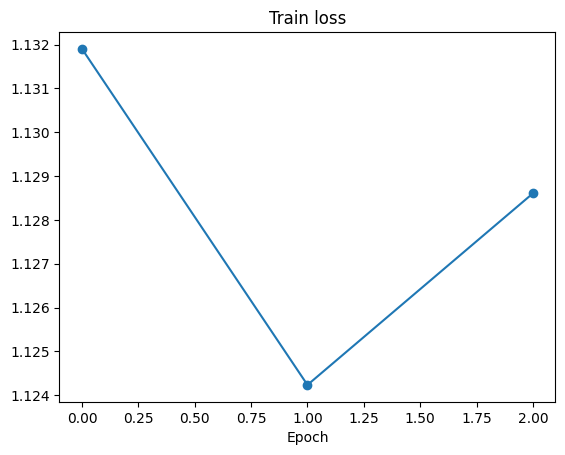

Validation Accuracy: 0.3333333333333333
Precision, Recall, F1 (weighted): 0.18333333333333332 0.3333333333333333 0.19158549783549786

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       0.00      0.00      0.00        27
           2       0.33      0.95      0.49        20

    accuracy                           0.33        60
   macro avg       0.22      0.34      0.21        60
weighted avg       0.18      0.33      0.19        60



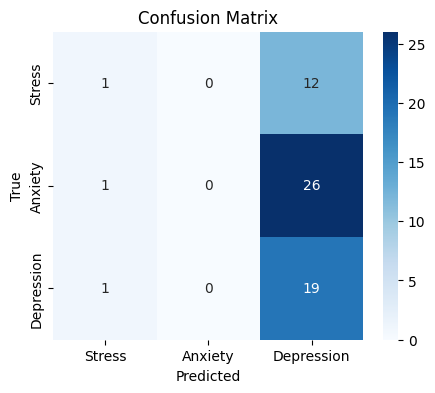

Saved checkpoint to checkpoints/multimodal_demo.pth
True label: 1 Predicted: 2


In [1]:


# ------------------------------
# 1) Imports & Setup
# ------------------------------
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
# set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# ------------------------------
# 2) Model Definitions
# ------------------------------

# 2.1 Image encoder using ResNet18 (transfer learning)
class ImageEncoder(nn.Module):
    def __init__(self, out_features=128, pretrained=True):
        super().__init__()
        # Use pretrained ResNet18 (set pretrained=False if offline)
        self.backbone = models.resnet18(pretrained=pretrained)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feat, out_features)
    def forward(self, x):
        return self.backbone(x)

# 2.2 Text encoder using Embedding + LSTM
class TextEncoder(nn.Module):
    def __init__(self, vocab_size=5000, embed_dim=64, hidden_dim=128, out_features=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, out_features)
    def forward(self, x):  # x: (batch, seq_len)
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)
        _, (hn, _) = self.lstm(emb)  # hn: (num_layers * num_directions, batch, hidden_dim)
        last = hn[-1]  # (batch, hidden_dim)
        return self.fc(last)  # (batch, out_features)

# 2.3 Multimodal classifier (concatenate features)
class MultimodalClassifier(nn.Module):
    def __init__(self, img_encoder, text_encoder, num_classes=3):
        super().__init__()
        self.img_encoder = img_encoder
        self.text_encoder = text_encoder
        combined_dim = 128 + 128
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, img, text):
        img_feat = self.img_encoder(img)   # (batch, 128)
        text_feat = self.text_encoder(text)  # (batch, 128)
        combined = torch.cat([img_feat, text_feat], dim=1)
        return self.classifier(combined)

# ------------------------------
# 3) Synthetic Dataset (Demo)
# ------------------------------
# Replace this cell with real dataset loading for actual training.
class SyntheticDermatoTextDataset(Dataset):
    def __init__(self, n_samples=200, seq_len=8, img_size=(224,224)):
        self.n = n_samples
        self.seq_len = seq_len
        self.img_size = img_size
        # small synthetic vocabulary (1..vocab_size-1). 0 reserved for padding.
        self.vocab_size = 100
        # transform for images
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        # create a random RGB image
        img_arr = (np.random.rand(self.img_size[0], self.img_size[1], 3) * 255).astype(np.uint8)
        img = Image.fromarray(img_arr)
        img = self.transform(img)
        # random text tokens
        text = np.random.randint(1, self.vocab_size, size=(self.seq_len,))
        text = torch.tensor(text, dtype=torch.long)
        # random label among 3 classes
        label = np.random.randint(0,3)
        return img, text, label

# small dataset for demo
train_ds = SyntheticDermatoTextDataset(n_samples=240)
val_ds = SyntheticDermatoTextDataset(n_samples=60)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)

print("Demo dataset ready. Train:", len(train_ds), "Val:", len(val_ds))

# ------------------------------
# 4) Utilities: Collate, metrics & plotting
# ------------------------------
def pad_batch_text(batch_texts, pad_token=0):
    # batch_texts: list of 1D tensors (seq_len each)
    lengths = [t.shape[0] for t in batch_texts]
    maxlen = max(lengths)
    batch = torch.zeros(len(batch_texts), maxlen, dtype=torch.long)
    for i,t in enumerate(batch_texts):
        batch[i, :t.shape[0]] = t
    return batch

def evaluate_model(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for imgs, texts, labels in loader:
            imgs = imgs.to(device)
            # pad texts to same length in batch (our synthetic has fixed length, but safe)
            texts = pad_batch_text(texts).to(device)
            outputs = model(imgs, texts)
            batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(batch_preds.tolist())
            trues.extend(labels.numpy().tolist())
    acc = accuracy_score(trues, preds)
    prfs = precision_recall_fscore_support(trues, preds, average='weighted', zero_division=0)
    return acc, prfs, trues, preds

def plot_confusion(trues, preds, classes=None, title="Confusion Matrix"):
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.show()

# ------------------------------
# 5) Initialize models, optimizer, loss
# ------------------------------
# create encoders (use pretrained=True for ResNet if you have Internet / weights)
img_encoder = ImageEncoder(out_features=128, pretrained=False)   # set pretrained=True when online
text_encoder = TextEncoder(vocab_size=100, embed_dim=64, hidden_dim=128, out_features=128)
model = MultimodalClassifier(img_encoder, text_encoder, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Model initialized. Parameters:", sum(p.numel() for p in model.parameters()))

# ------------------------------
# 6) Training loop (demo: 3 epochs)
# ------------------------------
n_epochs = 3
train_losses = []
val_accuracies = []
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for imgs, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        imgs = imgs.to(device)
        texts = pad_batch_text(texts).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    # validation
    val_acc, val_prfs, val_trues, val_preds = evaluate_model(model, val_loader)
    val_accuracies.append(val_acc)
    print(f"\nEpoch {epoch+1} - Train Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f}")

# plot training loss
plt.figure(); plt.plot(train_losses, marker='o'); plt.title("Train loss"); plt.xlabel("Epoch"); plt.show()

# ------------------------------
# 7) Final evaluation & metrics
# ------------------------------
val_acc, (prec, rec, f1, _), val_trues, val_preds = evaluate_model(model, val_loader)
print("Validation Accuracy:", val_acc)
print("Precision, Recall, F1 (weighted):", prec, rec, f1)
print("\nClassification Report:\n", classification_report(val_trues, val_preds, zero_division=0))
plot_confusion(val_trues, val_preds, classes=["Stress","Anxiety","Depression"])

# ------------------------------
# 8) Save checkpoint
# ------------------------------
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = os.path.join("checkpoints", "multimodal_demo.pth")
torch.save(model.state_dict(), ckpt_path)
print("Saved checkpoint to", ckpt_path)

# ------------------------------
# 9) Single-sample demo (load & inference)
# ------------------------------
# pick first val sample
img, text, label = val_ds[0]
model.eval()
with torch.no_grad():
    img_b = img.unsqueeze(0).to(device)
    text_b = text.unsqueeze(0).to(device)
    out = model(img_b, text_b)
    pred = torch.argmax(out, dim=1).item()
print("True label:", label, "Predicted:", pred)
